# Updated Random Forest Code

Streamlining the process and ensuring analysis includes appropriate measures.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
plt.style.use('seaborn-colorblind')

## Import the data and the question strings

In [2]:
folder='../../ComputationSurveyData/';
XLS = pd.ExcelFile(folder + 'LabeledComputationData.xlsx')
XLS2 = pd.ExcelFile(folder + 'CategorizedQuestions.xlsx')
df = XLS.parse('LabeledComputationData')
questions = XLS2.parse('Sheet1')

### Selecting the question to classify and input features to use to predict classifications

In [3]:
question_to_classify = 'Q1'

feature_subset = questions[((questions['context'] == 'test') |
                            (questions['context'] == 'background') |
                           (questions['context'] == 'demographics')) & 
                           (questions['qtype'] != 'open')];

### Randomly select the training data
Add a new key ```is_train``` to the data frame, which is a random selection of the data

In [4]:
training_proportion = .75
df['is_train'] = np.random.uniform(0, 1, len(df)) <= training_proportion

### Add new keys that factorize our original data set
The classifer requires that the data be represented as numbers, so it will assign a unique integer for each unique string in a given key.

In [5]:
features = []
for ID in feature_subset.id:

    new_header = ID + 'feature'
    df[new_header] = pd.factorize(df[ID])[0]
    features.append(new_header)

### Create two new dataframes, one with the training rows, one with the test rows

In [6]:
train, test = df[df['is_train'] == True], df[df['is_train'] == False]

### Create two new data frames for the classifications and store the input data
```train[question]``` contains the classes of the data. Before we can use it, we need to convert each result into a digit. 

In [7]:
y = pd.factorize(train[question_to_classify])[0]
y_test = pd.factorize(test[question_to_classify])[0]
X = train[features]
X_test = test[features]

# Rescale the input data
Scaling of the data (using z-scores) ensures that each values for each key are on the same scale so that fits aren't overwhelmed by vastly different scaled variables.

In [8]:
# Scaling to ensure it doesn't behave badly
scaler = StandardScaler()
scaler.fit(X)

# Now apply the transformations to the data:
X = scaler.transform(X)
X_test = scaler.transform(X_test)

### Run the random forest and fit the data

In [9]:
# Create a random forest classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier(n_estimators=128);

# Train the classifier to take the training features, X, and learn how they relate
# to the training classes, y
clf.fit(X, y);

# Apply the classifier we trained to the test data (which, remember, it has never seen before)
pred_y_test = clf.predict(X_test);

fs = feature_subset['feature'].tolist()

for feature in zip(fs, clf.feature_importances_):
    print(feature)

('Q152feature', 0.016732747437852791)
('Q153feature', 0.029755858395701201)
('Q154feature', 0.017968619616910174)
('Q155feature', 0.12637323311516258)
('Q156feature', 0.021246053900079311)
('Q157feature', 0.025781755113664172)
('Q158feature', 0.024234570195986613)
('Q160feature', 0.021895588024240492)
('Q161feature', 0.18664221058784267)
('Q162feature', 0.024896015436970908)
('Q163feature', 0.077102114068334268)
('Q164feature', 0.051901055154871874)
('Q166feature', 0.058513090712620112)
('Q168feature', 0.02106225909968417)
('Q169feature', 0.033103504687904316)
('Q170feature', 0.023142751405297198)
('Q171feature', 0.0043420217785862907)
('Q172feature', 0.0060419544498202934)
('Q173feature', 0.0026643454586246268)
('Q174feature', 0.016254318079838299)
('Q175feature', 0.019474455442902515)
('Q176feature', 0.012030169601405806)
('Q177feature', 0.007432708311560148)
('Q178feature', 0.0088551859258665377)
('Q185feature', 0.012743983803908884)
('Q186feature', 0.084436954203652673)
('Q187featu

### Run analytics on the model

In [10]:
## Confusion Matrix
confusion = confusion_matrix(y_test,pred_y_test)
print('Confusion Matrix:\n',confusion)

## Check accuracy of model on test data
acc_score = accuracy_score(y_test, pred_y_test);
print('Percentage of accurate predictions:\n', acc_score)

## Compute predicted class probabilities
preds = clf.predict_proba(X_test)

## Determine false positive and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, preds[:,1])

## Store rates for plotting
dfROC = pd.DataFrame(dict(fpr = fpr, tpr = tpr))

## Compute area under curve of ROC
area_under_curve = auc(fpr,tpr)
print('Area under curve:\n', area_under_curve)

Confusion Matrix:
 [[ 74  51]
 [ 28 160]]
Percentage of accurate predictions:
 0.747603833866
Area under curve:
 0.813425531915


### Plot the ROC curve

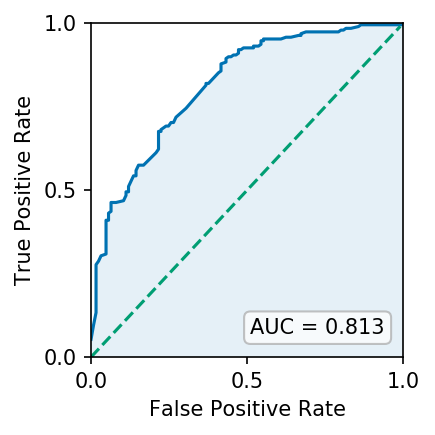

In [11]:
#just to plot guessing line
a = np.arange(0,1,0.01)

bboxprops = {'facecolor':'white', 'pad':0.3, 'boxstyle':'round', 'edgecolor':'darkgrey', 'alpha':0.7}

fig1 = plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

plt.plot(dfROC['fpr'],dfROC['tpr'],'-')
plt.plot(a,a,'--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax1.fill_between(dfROC['fpr'], 0, dfROC['tpr'],alpha=0.1)
ax1.text(0.51, 0.07, 'AUC = '+ str(round(area_under_curve, 3)), bbox = bboxprops)
plt.axis([0,1,0,1])
plt.xticks([0,0.5,1])
plt.yticks([0,0.5,1])

plt.tight_layout()

In [23]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
sfm = SelectFromModel(clf, threshold=0.05)

# Train the selector
sfm.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold=0.05)

In [24]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(fs[feature_list_index])

Q155feature
Q161feature
Q163feature
Q164feature
Q166feature
Q186feature
Q187feature


In [25]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X)
X_important_test = sfm.transform(X_test)

In [26]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=128, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [27]:
# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

In [28]:
## Confusion Matrix
confusion = confusion_matrix(y_test,y_important_pred)
print('Confusion Matrix:\n',confusion)

## Check accuracy of model on test data
acc_score = accuracy_score(y_test, y_important_pred);
print('Percentage of accurate predictions:\n', acc_score)

## Compute predicted class probabilities
preds = clf_important.predict_proba(X_important_test)

## Determine false positive and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, preds[:,1])

## Store rates for plotting
dfROC = pd.DataFrame(dict(fpr = fpr, tpr = tpr))

## Compute area under curve of ROC
area_under_curve = auc(fpr,tpr)
print('Area under curve:\n', area_under_curve)

Confusion Matrix:
 [[ 72  53]
 [ 31 157]]
Percentage of accurate predictions:
 0.731629392971
Area under curve:
 0.788914893617


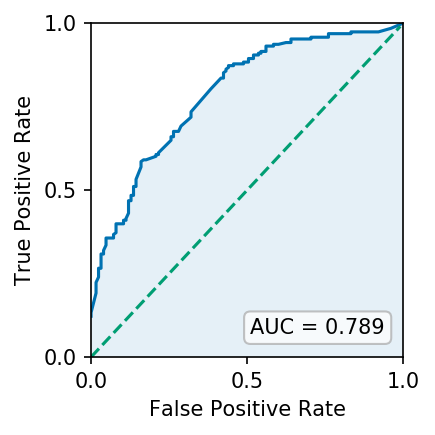

In [29]:
#just to plot guessing line
a = np.arange(0,1,0.01)

bboxprops = {'facecolor':'white', 'pad':0.3, 'boxstyle':'round', 'edgecolor':'darkgrey', 'alpha':0.7}

fig1 = plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

plt.plot(dfROC['fpr'],dfROC['tpr'],'-')
plt.plot(a,a,'--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax1.fill_between(dfROC['fpr'], 0, dfROC['tpr'], alpha=0.1)
ax1.text(0.51, 0.07, 'AUC = '+ str(round(area_under_curve, 3)), bbox = bboxprops)
plt.axis([0,1,0,1])
plt.xticks([0,0.5,1])
plt.yticks([0,0.5,1])

plt.tight_layout()